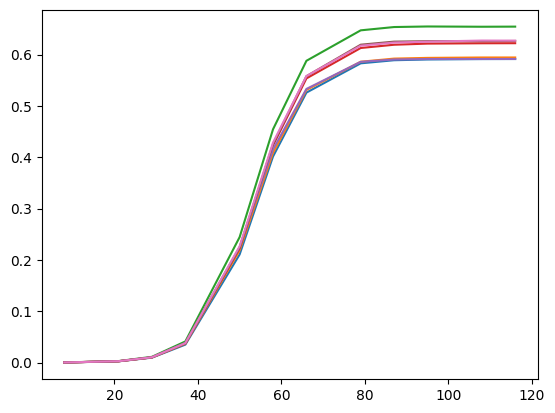

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import sbi.utils as utils
import torch
from sbi.inference import MCMCPosterior
from scipy.special import logsumexp
from seaborn import histplot
from time import time
import sys  
sys.path.insert(1, '../')
from collective_posterior import CollectivePosterior
from simulators import WF, WF_wrapper
generation = np.array(pd.read_csv('empirical_data/Chuong_116_gens.txt').columns.astype('int'))


def simulator(parameters, n=10, to_noise=False):
    noise = np.arange(len(generation)).astype('float')
    noise /= noise.sum()
    if to_noise != 0:
        noise = np.random.normal(0,to_noise*noise,(n,len(generation)))
        X = WF_wrapper(parameters=parameters, seed=None, reps=n) + noise
    else:
        X = WF_wrapper(parameters=parameters, seed=None, reps=n)
    for i in range(len(X)):
        for j in range(len(X[i])):
            if X[i,j] > 1:
                X[i,j] = 1
            if X[i,j] < 0:
                X[i,j] = 0
    return X

th = torch.tensor([-0.74,-4.84,-4.32], dtype=torch.float32)
X = simulator(th.numpy(), n=7, to_noise=0) # LTRΔ MAP in paper
# X_emp = torch.from_numpy(np.array(pd.read_csv('empirical_data/ltr.csv', index_col=0)))

for x in X:
    plt.plot(generation,x)

In [17]:
from sbi.inference import NPSE

prior_min = np.log10(np.array([1e-2,1e-7,1e-8]))
prior_max = np.log10(np.array([1,1e-2,1e-2]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))

num_sims = 10000
theta = prior.sample((num_sims,))
x = torch.empty(10000, 12)
for i in range(10000):
    x[i] = WF(theta[i])

inference = NPSE(prior, sde_type="ve")
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior().set_default_x(X[0])


 Neural network successfully converged after 1230 epochs.

In [23]:
posterior.set_default_x(X[5]).sample((1000,)).mean(0)

Drawing 1000 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

tensor([-0.7052, -5.0552, -4.6126])

In [2]:
prior_min = np.log10(np.array([1e-2,1e-7,1e-8]))
prior_max = np.log10(np.array([1,1e-2,1e-2]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))
posterior_chuong = pickle.load(open('posteriors/posterior_WF_100000_100.pkl', 'rb'))
epsilon = -150

Xs = torch.tensor(X)
op = CollectivePosterior(prior, posterior_chuong, Xs, 1, epsilon)

print(op.get_log_C())

/tmp/ipykernel_4167614/2869014794.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xs = torch.tensor(X)


tensor(-54.8380)


/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

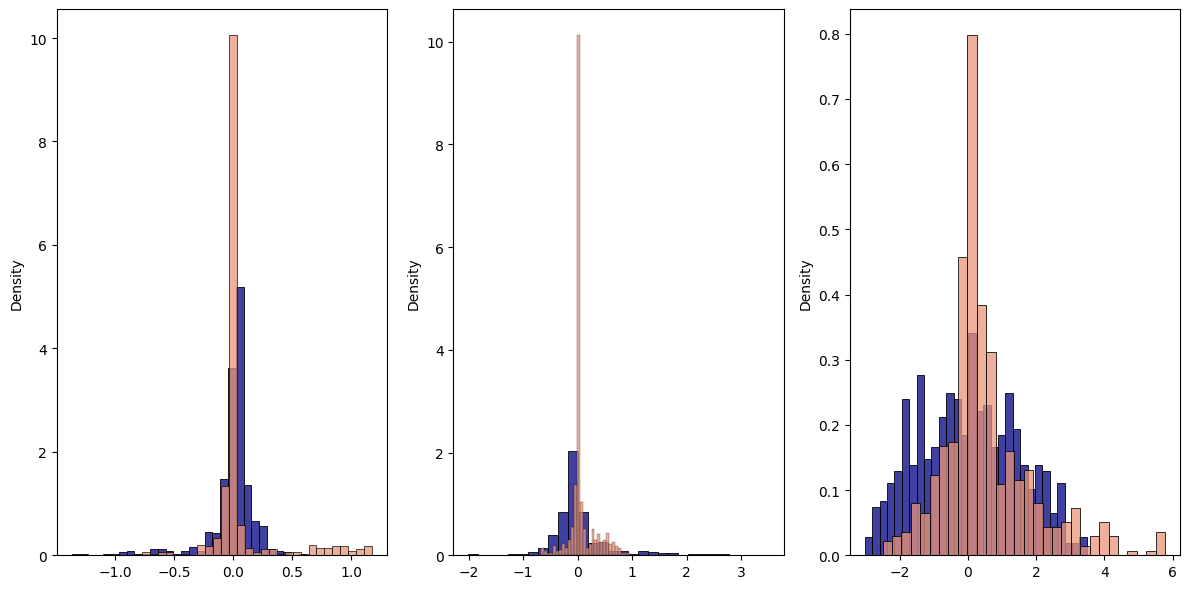

In [9]:
def plot_accuracy(acc_path, ax, color):
    res = pd.read_csv(acc_path, index_col=0, dtype='float')
    res = torch.from_numpy(np.array(res))
    for i in range(len(ax)):
        histplot(res[:,i],ax=ax[i], stat='density', color=color, bins=30)
    return

n_params=3
fig, ax = plt.subplots(1,n_params, figsize=(12,6), tight_layout=True, sharex=False)


iid_acc = 'tests/accus_WF_iid.csv'
plot_accuracy(iid_acc, ax, color='navy')

cp_acc = 'tests/accus_WF.csv'
plot_accuracy(cp_acc, ax, color='darksalmon')


/tmp/ipykernel_1145943/312052045.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(covs, bins = 100, normed = True)
/tmp/ipykernel_1145943/312052045.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(covs, bins = 100, normed = True)


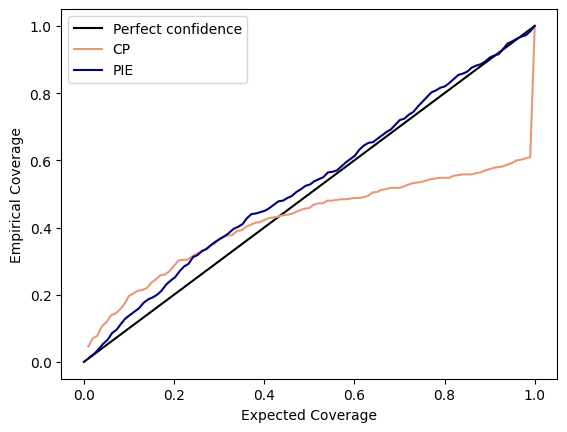

In [5]:
def plot_covs(covs, ax, label, color):
    H,X1 = np.histogram(covs, bins = 100, normed = True)
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax.plot(X1[1:], F1, label = label, color=color)

    ax.set_xlabel('Expected Coverage')
    ax.set_ylabel('Empirical Coverage')
    ax.legend()
    return

fig, ax = plt.subplots()
ax.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='k', label='Perfect confidence')
covs = pd.read_csv('tests/covs_WF.csv', index_col=0, dtype='float')
plot_covs(covs,ax,label='CP',color='darksalmon')

covs_iid = pd.read_csv('tests/covs_WF_iid.csv', index_col=0, dtype='float')
plot_covs(covs_iid,ax,label='PIE',color='navy')

/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

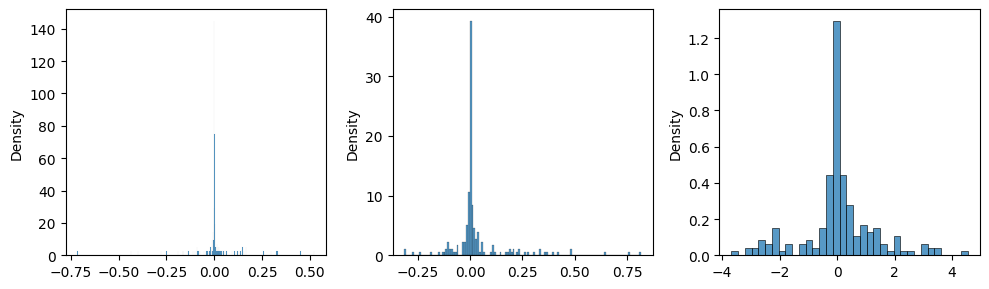

In [35]:
from seaborn import histplot
fig, ax = plt.subplots(1,3, figsize=(10,3), tight_layout = True)
histplot(res_cp[:,0],ax=ax[0], stat='density')
histplot(res_cp[:,1],ax=ax[1], stat='density')
histplot(res_cp[:,2],ax=ax[2], stat='density')

In [9]:
# ACC
from seaborn import histplot as hst

def acc(posterior, thetas, eps, c_samples):
    accus = torch.empty(thetas.shape)
    covs = torch.empty(len(thetas),1)
    for i in range(len(thetas)):
        cp = CollectivePosterior(prior=prior, amortized_posterior=posterior, log_C=1, Xs=WF_wrapper(10, thetas[i]),epsilon=eps)
        cp.get_log_C(samples=c_samples)
        samples = cp.sample(200)
        params = torch.tensor(thetas[i,:], dtype=torch.float32)
        accus[i] = samples.mean(0)-params
        covs[i] = (cp.log_prob(samples) > cp.log_prob(params)).sum()/len(thetas)
        print(i, accus[i], covs[i])
    return accus, covs

thetas = pd.read_csv('tests/test_thetas.csv', index_col=0).iloc[:200,]
thetas = torch.tensor(np.array(thetas), dtype=torch.float32)

/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_1915386/2897170975.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(thetas[i,:], dtype=torch.float32)


0 tensor([-0.0744,  0.0071, -5.1459]) tensor([0.])
1 tensor([ 0.0225, -0.2669, -0.2180]) tensor([0.])
2 tensor([ 0.0024, -0.0138,  1.1484]) tensor([0.0550])
3 tensor([ 0.0969, -0.6280, -0.7709]) tensor([0.])
4 tensor([-0.0720,  0.0120,  0.4126]) tensor([0.0050])
5 tensor([ 0.0737, -0.0969,  0.8932]) tensor([0.5000])
6 tensor([-0.0036, -0.0014,  0.4945]) tensor([0.0050])
7 tensor([ 0.0816, -0.2673, -0.9258]) tensor([1.])
8 tensor([-0.0016, -0.0042, -0.8494]) tensor([0.])


KeyboardInterrupt: 

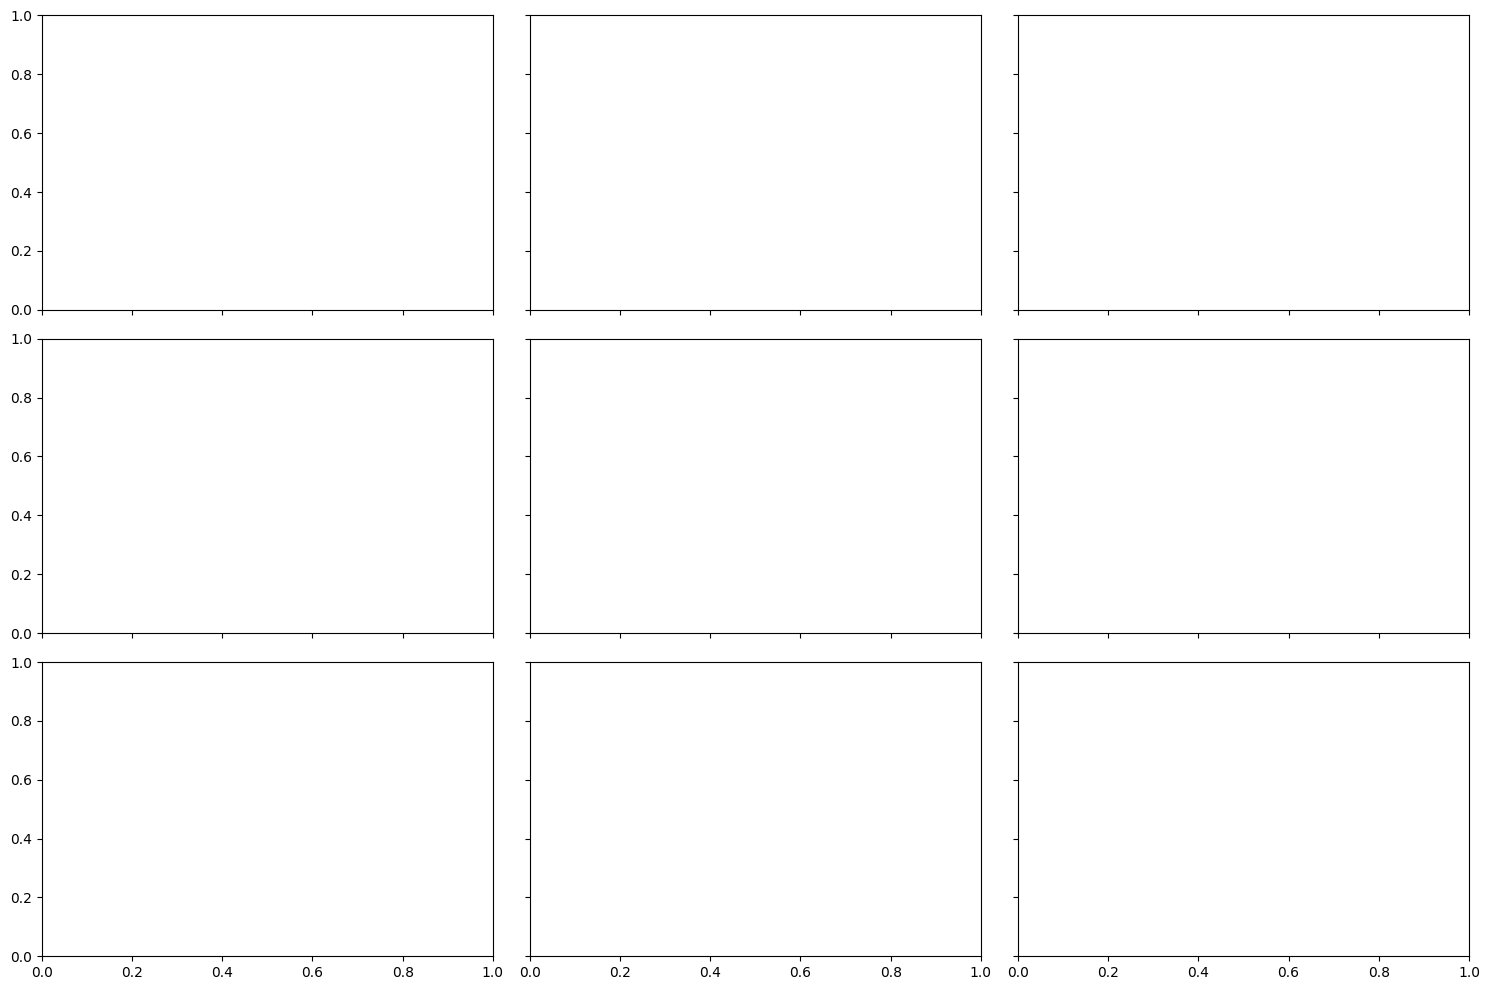

In [10]:

    
fig, ax = plt.subplots(3,3, figsize=(15,10), tight_layout=True, sharex=True, sharey=True)
c_samps = [1000, 10000, 100000]
epsilons = [-150,-1000,-10000]
for i in range(3):
    eps = epsilons[i]
    for j in range(3):
        c_samples = c_samps[j]
        accs = acc(posterior_chuong, thetas, eps, c_samples)
        ax[i,j].set_title(f'log ϵ = {int(epsilons[i])}\nImportance samples = {c_samps[j]}')
        hst(accs, ax=ax[i,j], stat='density')
        print(i,j)
fig.supxlabel('Expected Coverage')
fig.supylabel('Empirical Coverage')
ax[2,2].legend()

/tmp/ipykernel_1915386/2897170975.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(thetas[i,:], dtype=torch.float32)


0 tensor([-0.0095, -0.0022, -0.6104]) tensor([0.0850])
1 tensor([ 0.0051, -0.0497, -0.0431]) tensor([0.0200])
2 tensor([3.6538e-05, 1.2932e-03, 1.0805e+00]) tensor([1.])
3 tensor([ 0.0251, -0.0437, -0.1166]) tensor([0.7400])
4 tensor([-1.0597e-03,  6.5804e-04,  3.3086e+00]) tensor([0.6200])
5 tensor([ 0.0769, -0.0991,  1.2013]) tensor([0.8400])
6 tensor([-0.0010,  0.0017,  0.0358]) tensor([0.])


KeyboardInterrupt: 

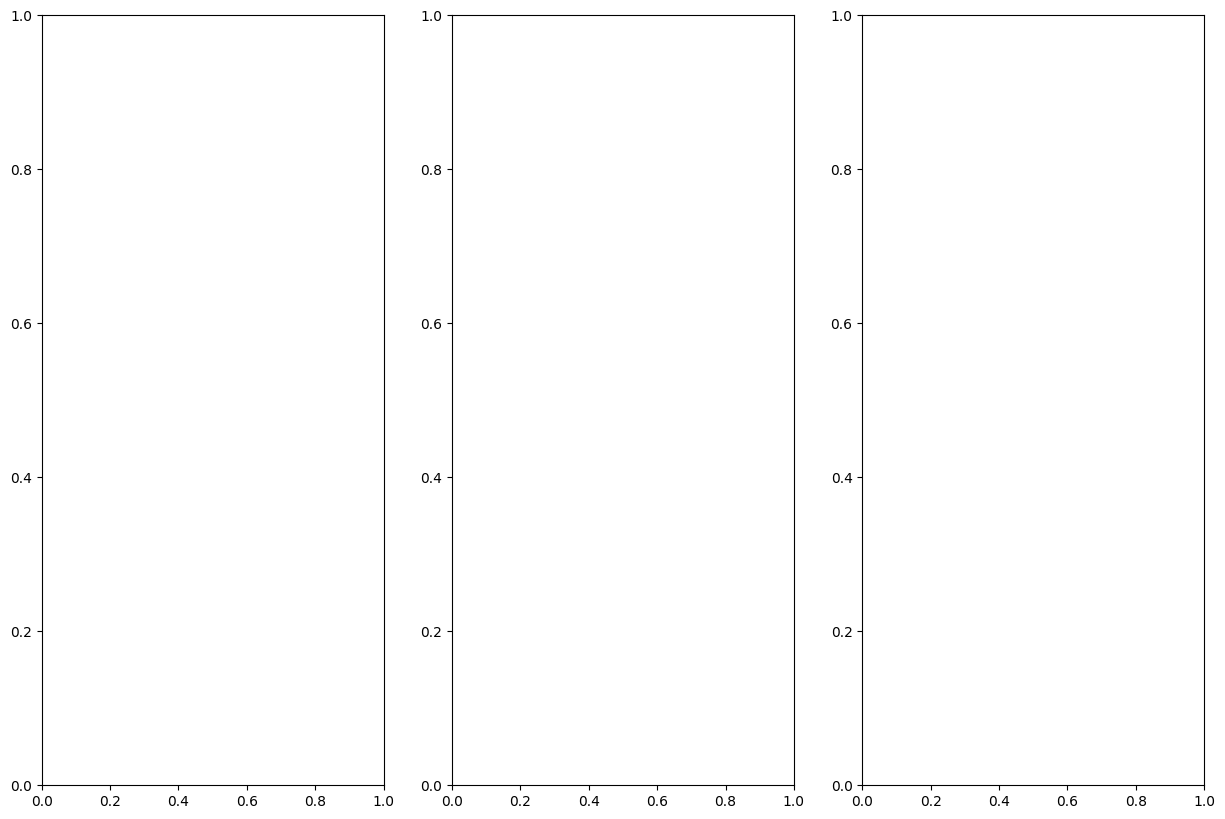

In [11]:
fig, ax = plt.subplots(1,3, figsize=(15,10))
accs, covs = acc(posterior_chuong, thetas, eps=-10000, c_samples=int(1e5))
for j in range(3):
        hst(accs[:,j], ax=ax[j], stat='density')

/tmp/ipykernel_3182317/1468576063.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(covs, bins = 100, normed = True)


<Axes: >

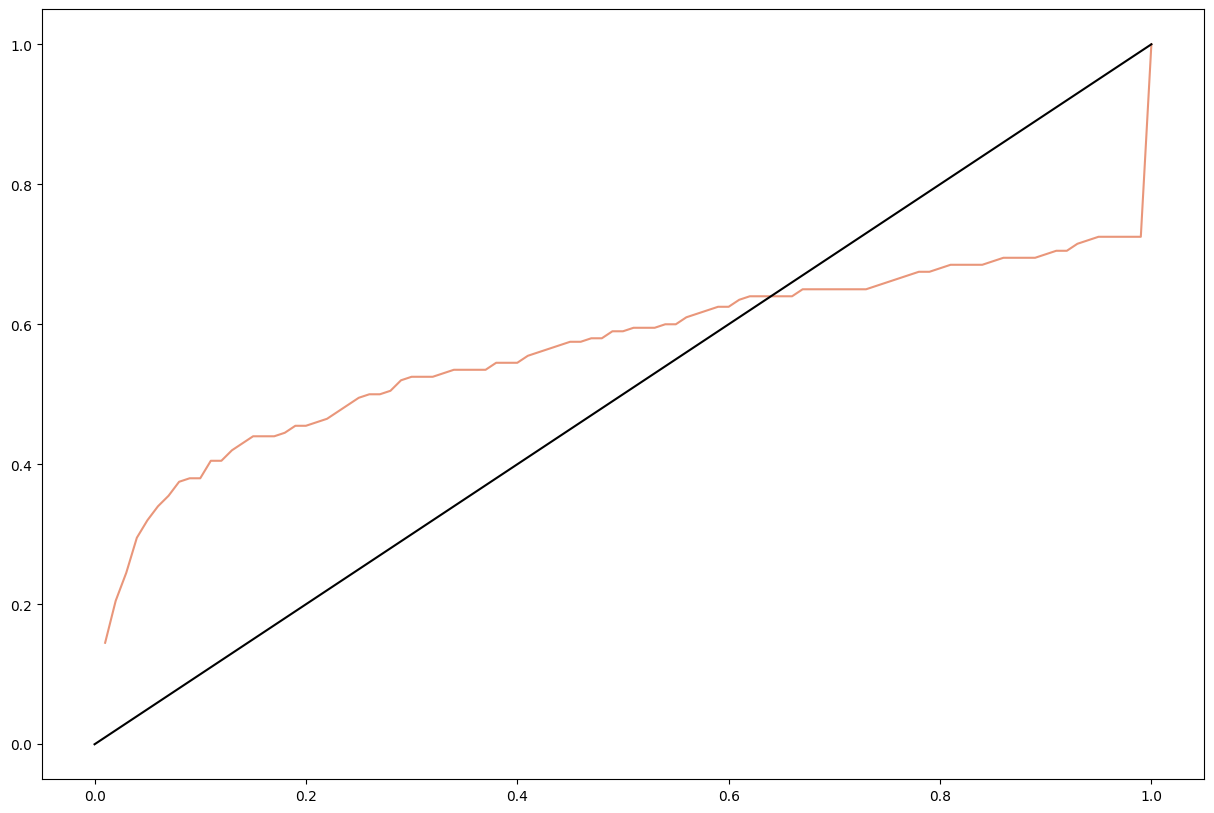

In [34]:
def plot_covs(covs, ax):
    H,X1 = np.histogram(covs, bins = 100, normed = True)
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax.plot(X1[1:], F1, label = 'CP', color='darksalmon')
    ax.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='k', label='Perfect confidence')
    return ax

fig, ax = plt.subplots(figsize=(15,10))
plot_covs(covs, ax)
# fig

In [21]:
thetas = pd.read_csv('tests/test_thetas.csv', index_col=0).iloc[:200,]
# thetas = torch.tensor(np.array(thetas), dtype=torch.float32)

sbi_posterior = pickle.load(open(f'posteriors/posterior_iid_WF_100000_100_2.pkl', 'rb'))
res_iid = np.zeros_like(np.array(thetas))
for i in range(len(thetas)):
    theta = thetas.iloc[i]
    Xs = simulator(np.array(theta))
    m = sbi_posterior.set_default_x(Xs).sample((200,)).mean(0).numpy()
    res_iid[i] = m - theta
    print(i)

/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sbi/utils/user_input_checks.py:585: UserWarning: An x with a batch size of 10 was passed. Unless you are using `sample_batched` or `log_prob_batched`, this will be interpreted as a batch of independent and identically distributed data X={x_1, ..., x_n}, i.e., data generated based on the same underlying(unknown) parameter. The resulting posterior will be with respect to the entire batch, i.e,. p(theta | X).
  warn_on_batched_x(batch_size=input_x_shape[0])


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

0


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

1


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

2


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

3


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

4


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

5


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

6


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

7


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

8


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

9


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

10


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

11


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

12


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

13


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

14


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

15


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

16


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

17


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

18


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

19


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

20


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

21


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

22


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

23


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

24


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

25


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

26


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

27


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

28


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

29


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

30


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

31


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

32


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

33


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

34


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

35


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

36


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

37


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

38


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

39


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

40


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

41


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

42


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

43


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

44


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

45


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

46


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

47


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

48


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

49


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

50


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

51


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

52


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

53


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

54


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

55


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

56


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

57


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

58


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

59


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

60


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

61


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

62


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

63


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

64


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

65


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

66


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

67


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

68


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

69


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

70


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

71


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

72


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

73


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

74


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

75


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

76


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

77


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

78


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

79


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

80


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

81


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

82


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

83


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

84


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

85


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

86


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

87


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

88


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

89


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

90


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

91


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

92


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

93


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

94


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

95


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

96


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

97


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

98


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

99


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

100


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

101


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

102


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

103


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

104


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

105


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

106


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

107


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

108


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

109


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

110


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

111


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

112


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

113


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

114


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

115


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

116


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

117


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

118


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

119


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

120


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

121


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

122


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

123


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

124


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

125


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

126


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

127


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

128


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

129


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

130


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

131


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

132


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

133


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

134


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

135


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

136


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

137


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

138


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

139


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

140


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

141


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

142


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

143


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

144


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

145


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

146


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

147


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

148


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

149


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

150


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

151


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

152


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

153


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

154


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

155


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

156


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

157


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

158


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

159


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

160


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

161


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

162


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

163


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

164


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

165


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

166


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

167


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

168


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

169


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

170


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

171


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

172


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

173


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

174


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

175


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

176


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

177


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

178


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

179


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

180


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

181


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

182


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

183


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

184


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

185


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

186


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

187


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

188


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

189


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

190


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

191


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

192


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

193


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

194


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

195


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

196


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

197


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

198


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

199


/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

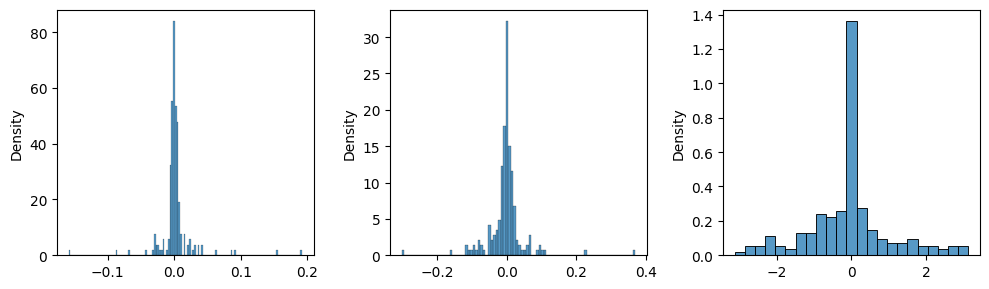

In [31]:
fig, ax = plt.subplots(1,3, figsize=(10,3), tight_layout = True)

histplot(res_iid[:,0],ax=ax[0], stat='density')
histplot(res_iid[:,1],ax=ax[1], stat='density')
histplot(res_iid[:,2],ax=ax[2], stat='density')

In [7]:
pd.DataFrame(res_iid).to_csv('tests/test_eval_iid_WF_10000_100.csv')

In [13]:
# eval for diffusion posterior

prior_min_t = np.log10(np.array([1e-1,1e-6,1e-6]))
prior_max_t = np.log10(np.array([0.2,1e-4,1e-4]))
test_prior = utils.BoxUniform(low=torch.tensor(prior_min_t), 
                         high=torch.tensor(prior_max_t))

thetas = pd.read_csv('tests/test_thetas.csv').iloc[:,1:]
res = np.zeros_like(thetas)

for i in range(len(thetas)):
    theta = torch.tensor(thetas.iloc[i,:], dtype=torch.float32)
    Xs = WF(np.array(theta))
    m = posterior.set_default_x(Xs).sample((200,)).mean(0)
    res[i] = m - theta
    print(i)

fig, ax = plt.subplots(1,3, figsize=(10,3), tight_layout = True)

histplot(res[:,0],ax=ax[0], stat='density')
histplot(res[:,1],ax=ax[1], stat='density')
histplot(res[:,2],ax=ax[2], stat='density')

/tmp/ipykernel_4051860/3837262399.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  theta = torch.tensor(thetas.iloc[i,:], dtype=torch.float32)


NameError: name 'posterior' is not defined

/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

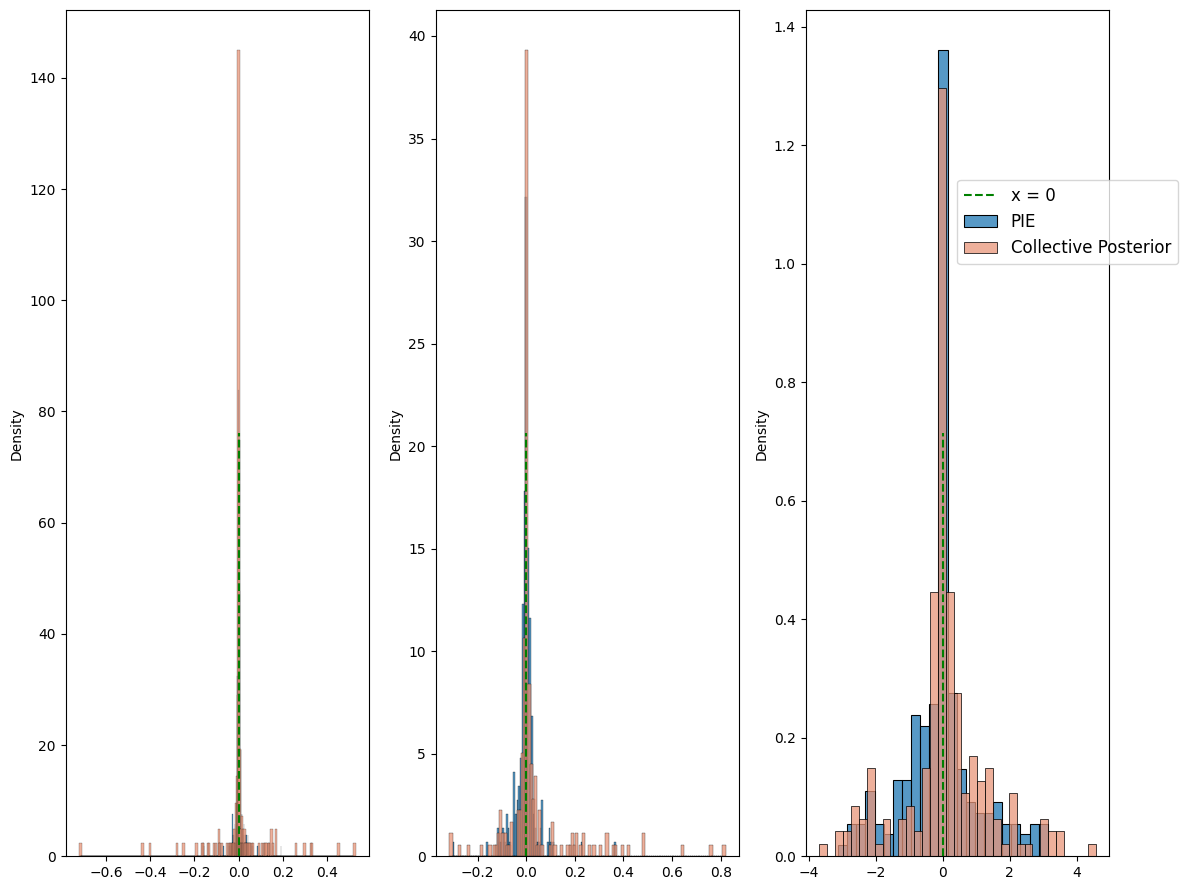

In [80]:
fig, ax = plt.subplots(1,3, figsize=(12,9), tight_layout = True)

# PIE
histplot(res_iid[:,0],ax=ax[0], stat='density', label='PIE')
histplot(res_iid[:,1],ax=ax[1], stat='density', label='PIE')
histplot(res_iid[:,2],ax=ax[2], stat='density', label='PIE')


# CP
histplot(res_cp[:,0],ax=ax[0], stat='density', color='darksalmon', label='Collective Posterior', shrink=5)
histplot(res_cp[:,1],ax=ax[1], stat='density', color='darksalmon', label='Collective Posterior', shrink=1.5)
histplot(res_cp[:,2],ax=ax[2], stat='density', color='darksalmon', label='Collective Posterior')

# ax[0].set_xlabel('GAP1 CNV \nselection coefficient', fontsize=12)
# ax[1].set_xlabel('GAP1 CNV \nformation rate', fontsize=12)
# ax[0].set_ylabel('Density', fontsize=12)
# ax[1].set_ylabel('Density', fontsize=12)

ax[0].axvline(0, color='green', ls = '--', ymax=0.5)
ax[1].axvline(0, color='green', ls = '--', ymax=0.5)
ax[2].axvline(0, color='green', ls = '--', ymax=0.5, label = 'x = 0')

# ax[0].set_yscale('log')
# ax[1].set_yscale('log')
# ax[2].set_yscale('log')

ax[2].legend(fontsize=12, loc=(0.5,0.7))

In [58]:
def coverage_old(posterior, conf_levels, thetas):
    covs = torch.empty(len(thetas),len(conf_levels), len(thetas[0]))
    for i in range(len(thetas)):
        cp = CollectivePosterior(prior=prior, amortized_posterior=posterior, log_C=1, Xs=WF_wrapper(10, thetas[i]),epsilon=-150)
        cp.get_log_C()
        num_samps = 200
        samples = cp.sample(num_samps)
        params = torch.tensor(thetas[i,:], dtype=torch.float32)
        sorted_probs, ind = torch.sort(cp.log_prob(samples), descending=True)
        for j in range(len(conf_levels)):
            conf_level = conf_levels[j]   
            samples_trimmed = samples[ind]
            probs = samples_trimmed[:int(conf_level*num_samps)+1]
            # hdi = [torch.quantile(samples, (1-conf_level)/2, 0), torch.quantile(samples,(1+conf_level)/2, 0)]
            hdi = [probs.min(0)[0], probs.max(0)[0]]
            covs[i,j] = ((params > hdi[0])*(params < hdi[1]))
        print(i)
    return covs, np.array(covs.mean(0))


posterior_chuong = pickle.load(open('posteriors/ensemble/ensemble_100000_20_ensemble.pkl', 'rb'))
thetas = pd.read_csv('tests/test_thetas.csv', index_col=0).iloc[:200,]
thetas = torch.tensor(np.array(thetas), dtype=torch.float32)
covs_cp_full, covs_cp_mean = coverage_old(posterior_chuong, conf_levels = [0.25, 0.5, 0.8, 0.95], thetas=thetas)

/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3182317/368093515.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(thetas[i,:], dtype=torch.float32)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [10]:
pd.DataFrame(covs_cp_mean).to_csv('covs_cp_15_12_24.csv')

In [56]:
covs_cp_full.sum(0)

tensor([[136., 143., 107.],
        [156., 158., 122.],
        [166., 170., 128.],
        [173., 176., 130.]])

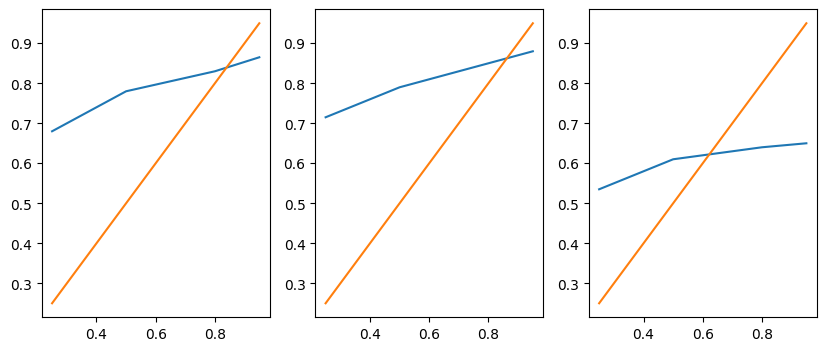

In [57]:
fig, ax = plt.subplots(1,3, figsize=(10,4))
conf_levels = [0.25, 0.5, 0.8, 0.95]
for i in range(3):
    covs = covs_cp_mean[:,i]
    ax[i].plot(conf_levels, covs)
    ax[i].plot(conf_levels, conf_levels)

In [ ]:
# COVERAGE

def coverage(posterior, thetas, eps, c_samples):
    covs = torch.empty(len(thetas),1)
    for i in range(len(thetas)):
        cp = CollectivePosterior(prior=prior, amortized_posterior=posterior, log_C=1, Xs=WF_wrapper(10, thetas[i]),epsilon=eps)
        cp.get_log_C(samples=c_samples)
        samples = cp.sample(200)
        params = torch.tensor(thetas[i,:], dtype=torch.float32)
        covs[i] = (cp.log_prob(samples) > cp.log_prob(params)).sum()/200
        print(i)
    return covs

def plot_covs(covs, ax):
    H,X1 = np.histogram(covs, bins = 100, normed = True)
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    ax.plot(X1[1:], F1, label = 'CP', color='darksalmon')
    ax.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='k', label='Perfect confidence')
    return
    
thetas = pd.read_csv('tests/test_thetas.csv', index_col=0).iloc[:200,]
thetas = torch.tensor(np.array(thetas), dtype=torch.float32)


In [161]:
fig, ax = plt.subplots(3,3, figsize=(15,10), tight_layout=True, sharex=True, sharey=True)
c_samps = [1000, 10000, 100000]
epsilons = [-150,-1000,-10000]
for i in range(3):
    eps = epsilons[i]
    for j in range(3):
        c_samples = c_samps[j]
        covs_cp = coverage(posterior_chuong, thetas, eps, c_samples)
        ax[i,j].set_title(f'log ϵ = {int(eps)}\nImportance samples = {c_samples}')
        plot_covs(covs_cp, ax=ax[i,j])
        plt.show()
fig.supxlabel('Expected Coverage')
fig.supylabel('Empirical Coverage')
ax[2,2].legend()

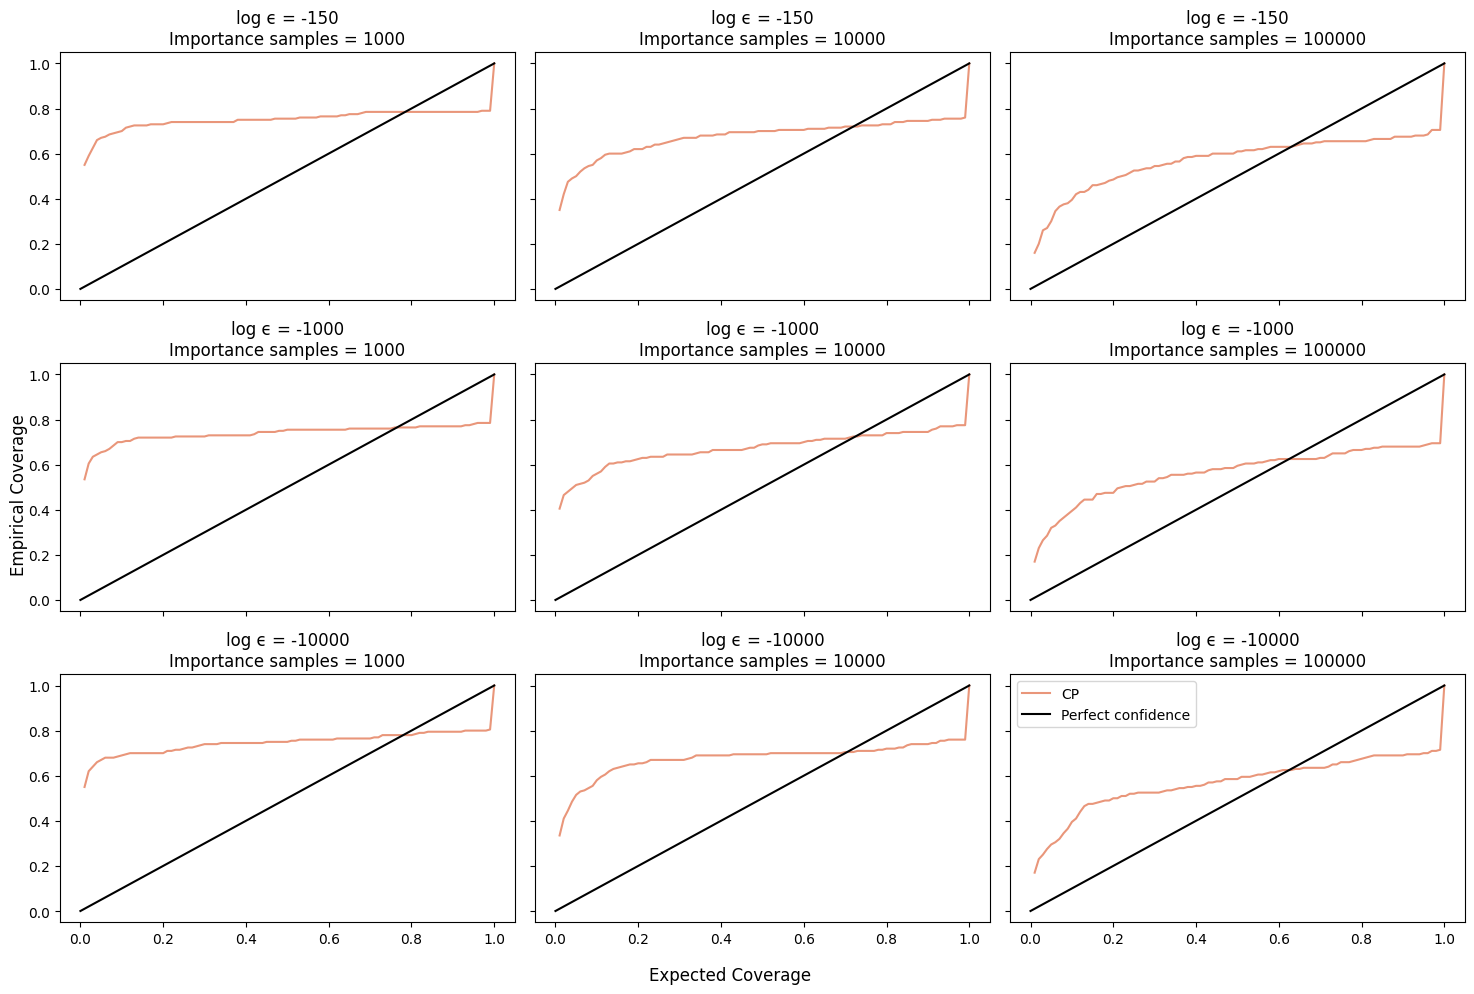

In [8]:
fig

/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_723776/3538359469.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(thetas[i,:], dtype=torch.float32)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


/tmp/ipykernel_723776/3538359469.py:15: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(covs, bins = 100, normed = True)


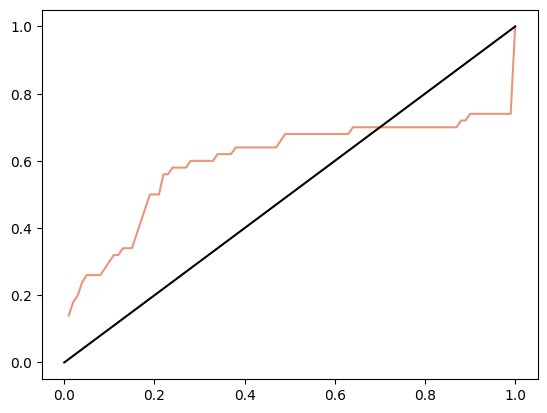

In [164]:
thetas = pd.read_csv('tests/test_thetas.csv', index_col=0).iloc[:50,]
thetas = torch.tensor(np.array(thetas), dtype=torch.float32)
fig, ax = plt.subplots()
plot_covs(coverage(posterior_chuong, thetas, eps=-10000, c_samples=int(1e6)), ax)

In [ ]:
H,X1 = np.histogram(covs_cp, bins = 100, normed = True)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
plt.plot(X1[1:], F1, label = 'CP', color='darksalmon')

# H,X1 = np.histogram(covs_ensemble, bins = 100, normed = True)
# dx = X1[1] - X1[0]
# F1 = np.cumsum(H)*dx
# plt.plot(X1[1:], F1, color='tan', label='Vanilla')

plt.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='k', label='Perfect confidence')

plt.xlabel('Expected Coverage')
plt.ylabel('Empirical Coverage')
plt.legend()

In [7]:
from arviz import hdi as get_hdi
# Get simulations

coverage = torch.zeros(size=(len(thetas[0]),1))
acc = 0.8
for i in range(len(thetas)):
    cp = CollectivePosterior(prior=prior, amortized_posterior=posterior_chuong, log_C=1, Xs=WF_wrapper(10, thetas[i]),epsilon=-150)
    cp.get_log_C()
    samples = cp.rejection_sample(20)
    hdi = get_hdi(samples.numpy(), hdi_prob=acc)
    for j in range(len(thetas[i])):
        h = hdi[j]
        param = thetas[i,j]
        covered = int(min( h[0] < param , param < h[1] ))
        coverage[j] += covered
    print(i)
        
coverage = coverage / len(thetas)

/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


0


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


1


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


2


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


3


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


4


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


5


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


6


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


7


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


8


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


9


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


10


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


11


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


12


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


13


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


14


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


15


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


16


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


17


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


18


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


19


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


20


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


21


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


22


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


23


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


24


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


25


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


26


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


27


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


28


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


29


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


30


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


31


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


32


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


33


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


34


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


35


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


36


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


37


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


38


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


39


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


40


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


41


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


42


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


43


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


44


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


45


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


46


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


47


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


48


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


49


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


50


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


51


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


52


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


53


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


54


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


55


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


56


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


57


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


58


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


59


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


60


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


61


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


62


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


63


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


64


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


65


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


66


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


67


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


68


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


69


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


70


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


71


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


72


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


73


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


74


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


75


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


76


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


77


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


78


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


79


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


80


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


81


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


82


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


83


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


84


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


85


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


86


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


87


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


88


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


89


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


90


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


91


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


92


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


93


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


94


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


95


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


96


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


97


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)
/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


98


/home/jupyter-nadavbennun/Nadav/Posterior/collective_posterior/WF/../collective_posterior.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(theta, dtype=torch.float32)


99


/tmp/ipykernel_3274707/82147533.py:10: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = get_hdi(samples.numpy(), hdi_prob=acc)


In [9]:
coverage = coverage * len(thetas)
coverage

tensor([[0.5800],
        [0.5900],
        [0.4600]])

In [42]:
def coverage_iid(posterior, thetas):
    covs = []
    for i in range(len(thetas)):
        params = torch.tensor(thetas[i,:], dtype=torch.float32)
        X = WF_wrapper(10, thetas[i])
        samples = posterior.set_default_x(X).sample((200,))
        covs.append((posterior.log_prob(samples) > posterior.log_prob(params)).sum()/200)
        print(i)
    return np.array(covs)

covs_iid = coverage_iid(sbi_posterior, thetas)

/tmp/ipykernel_1979461/865621120.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(thetas[i,:], dtype=torch.float32)
/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sbi/utils/user_input_checks.py:585: UserWarning: An x with a batch size of 10 was passed. Unless you are using `sample_batched` or `log_prob_batched`, this will be interpreted as a batch of independent and identically distributed data X={x_1, ..., x_n}, i.e., data generated based on the same underlying(unknown) parameter. The resulting posterior will be with respect to the entire batch, i.e,. p(theta | X).
  warn_on_batched_x(batch_size=input_x_shape[0])


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

0


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

1


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

2


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

3


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

4


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

5


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

6


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

7


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

8


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

9


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

10


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

11


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

12


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

13


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

14


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

15


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

16


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

17


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

18


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

19


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

20


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

21


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

22


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

23


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

24


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

25


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

26


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

27


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

28


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

29


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

30


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

31


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

32


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

33


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

34


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

35


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

36


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

37


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

38


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

39


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

40


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

41


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

42


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

43


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

44


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

45


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

46


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

47


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

48


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

49


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

50


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

51


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

52


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

53


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

54


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

55


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

56


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

57


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

58


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

59


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

60


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

61


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

62


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

63


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

64


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

65


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

66


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

67


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

68


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

69


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

70


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

71


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

72


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

73


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

74


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

75


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

76


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

77


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

78


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

79


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

80


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

81


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

82


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

83


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

84


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

85


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

86


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

87


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

88


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

89


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

90


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

91


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

92


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

93


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

94


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

95


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

96


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

97


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

98


Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

99


/tmp/ipykernel_1979461/3063945101.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(covs_iid, bins = 100, normed = True)


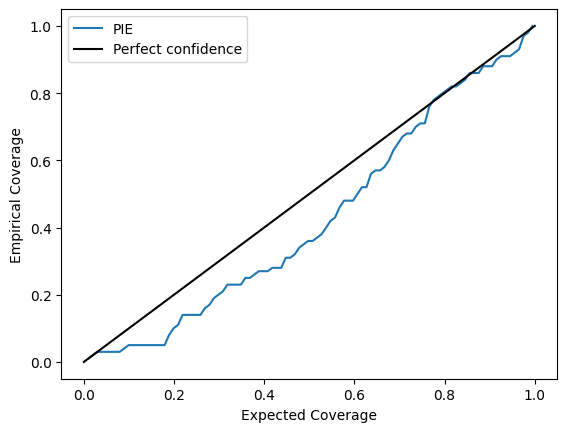

In [43]:
H,X1 = np.histogram(covs_iid, bins = 100, normed = True)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
plt.plot(X1[1:], F1, label = 'PIE')

plt.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='k', label='Perfect confidence')

plt.xlabel('Expected Coverage')
plt.ylabel('Empirical Coverage')
plt.legend()

/tmp/ipykernel_1979461/3533755502.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(covs_iid, bins = 100, normed = True)
/tmp/ipykernel_1979461/3533755502.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  H,X1 = np.histogram(covs_cp, bins = 100, normed = True)


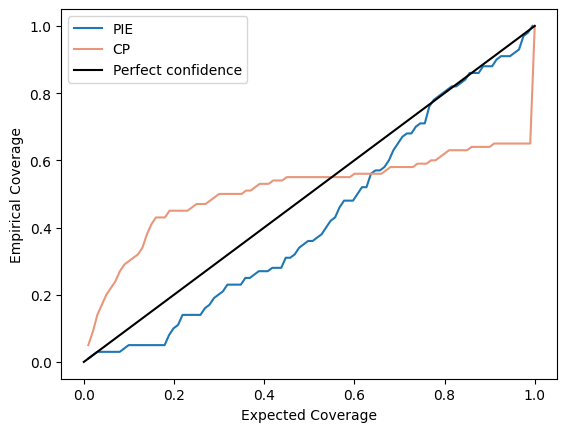

In [53]:
H,X1 = np.histogram(covs_iid, bins = 100, normed = True)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
plt.plot(X1[1:], F1, label = 'PIE')

H,X1 = np.histogram(covs_cp, bins = 100, normed = True)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
plt.plot(X1[1:], F1, label = 'CP', color='darksalmon')

plt.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='k', label='Perfect confidence')


plt.xlabel('Expected Coverage')
plt.ylabel('Empirical Coverage')
plt.legend()

In [3]:
from simulators import WF
from sbi.utils import BoxUniform
import torch
import pickle
import time
from sbi.inference import NPSE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

prior = BoxUniform(low=torch.tensor([-2, -7, -8]), high=torch.tensor([0, -2, -2]))

# time
start = time.time()

# Define the prior and simulator
sim = 'WF'
simulator = WF

# inference
# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)

# Inference
inference = NPSE(prior, sde_type='ve')

theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)
density_estimator = inference.append_simulations(theta, x).train(training_batch_size=200, stop_after_epochs=2)
posterior = inference.build_posterior(density_estimator)

# time
end = time.time()
print(f'Inference time: {end - start} seconds')

posterior.set_default_x(X).sample((100,)).mean(0)

2024-12-15 12:03:17.028799: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7098010a4670>>
Traceback (most recent call last):
  File "/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
2024-12-15 12:03:17.827470: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


  0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 3 epochs.Inference time: 3.4379916191101074 seconds


/home/jupyter-nadavbennun/.local/lib/python3.9/site-packages/sbi/utils/user_input_checks.py:585: UserWarning: An x with a batch size of 10 was passed. Unless you are using `sample_batched` or `log_prob_batched`, this will be interpreted as a batch of independent and identically distributed data X={x_1, ..., x_n}, i.e., data generated based on the same underlying(unknown) parameter. The resulting posterior will be with respect to the entire batch, i.e,. p(theta | X).
  warn_on_batched_x(batch_size=input_x_shape[0])


Drawing 100 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

NotImplementedError: Score accumulation for IID data is not yet implemented.